# T-Money taxi 수요 규제 선형 Regression 모델 예측  
__2020.04.28__
__유휘근__  
  
규제 선형 Regression 모델을 이용하여 선릉역 반경 150m에서 2018.10 ~ 2019.03 까지의 시간대(1h단위) 택시 승차 데이터로 수요 예측하기  

1. 방법론 : Regression (회귀)
2. 방법론에 사용할 알고리즘 및 라이브러리 
    - 라이브러리 : Python scikit-learn
    - 1.RidgeRegression(릿지회귀) - Python scikit-learn의 Ridge
    - 2.LassoRegression(라쏘회귀) - Python scikit-learn의 Lasso
    - 3.ElasticNetRegression(엘라스틱넷회귀) - Python scikit-learn의 ElasticNet
3. 알고리즘에 사용되는 파라미터 
    - 릿지회귀 : alpha (릿지회귀의 alpha L2(정규화) 규제 계수
    - 라쏘회귀 : alpha (라쏘회귀의 alpha L1(정규화) 규제 계수
    - 엘라스틱넷회귀 : L2규제와 L1규제의 결합. a x L1 + b x L2  alpha(a+b), l1_ratio(a/(a+b))
4. 평가방법  
  - 폴드 4 교차검증
  - MSE(Mean Squared Error) : 실제값과 예측값의 차이를 제곱해 평균한 것.
  - RMSE(Root Mean Squared Error) : MSE에 루트를 씌운 것.

## 모듈 import

In [173]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager as fm
from matplotlib import rc

# 시각화 그래프 '-' & 한글 깨짐 현상 처리
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc

mpl.rcParams['axes.unicode_minus'] = False
font_name = fm.FontProperties(fname='c:\\windows\\fonts\\malgun.ttf').get_name()
rc('font', family=font_name)

## 데이터 준비

### 데이터 로드

In [254]:
taxi = pd.read_csv('data/T-Money/seolleung_dataset.csv')
taxi

,o_time,yesterday,today,tomorrow,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,count
0,2018-10-01 00:00:00,1,0,0,14.1,2.6,55,0.0,0.0,0.0,2000,1.0,52
1,2018-10-01 01:00:00,1,0,0,13.9,2.0,57,2.0,0.0,0.0,2000,1.0,17
2,2018-10-01 02:00:00,1,0,0,13.9,2.4,56,4.0,0.0,0.0,2000,1.0,10
3,2018-10-01 03:00:00,1,0,0,13.6,1.6,56,8.0,0.0,0.0,2000,1.0,13
4,2018-10-01 04:00:00,1,0,0,13.7,1.9,56,10.0,0.0,0.0,2000,1.0,12
5,2018-10-01 05:00:00,1,0,0,13.7,1.8,57,8.0,0.0,0.0,1999,1.0,8
6,2018-10-01 06:00:00,1,0,0,13.3,2.3,56,7.0,0.0,0.0,2000,1.0,14
7,2018-10-01 07:00:00,1,0,0,13.1,2.1,58,3.0,0.0,0.0,1997,1.0,31
8,2018-10-01 08:00:00,1,0,0,13.7,2.4,54,7.0,0.0,0.0,1960,1.0,148
9,2018-10-01 09:00:00,1,0,0,14.9,3.4,50,1.0,0.0,0.0,1989,1.0,130


### 년 월 일 시간 변수 추가

In [255]:
# 시간 변수 추가를 위해 o_time 컬럼 데이터타입 문자열에서 datetime 으로 변경
taxi['o_time'] = taxi.o_time.apply(pd.to_datetime)
#taxi['o_time'] = pd.to_datetime(taxi['o_time'],format='%Y-%m-%d %H:%M:%S')

# datetime 타입에서 년,월,일,시간 추출
#taxi['year'] = taxi['o_time'].dt.year
#taxi['month'] = taxi['o_time'].dt.month
#taxi['day'] = taxi['o_time'].dt.day
taxi['hour'] = taxi['o_time'].dt.hour
taxi

,o_time,yesterday,today,tomorrow,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,count,hour
0,2018-10-01 00:00:00,1,0,0,14.1,2.6,55,0.0,0.0,0.0,2000,1.0,52,0
1,2018-10-01 01:00:00,1,0,0,13.9,2.0,57,2.0,0.0,0.0,2000,1.0,17,1
2,2018-10-01 02:00:00,1,0,0,13.9,2.4,56,4.0,0.0,0.0,2000,1.0,10,2
3,2018-10-01 03:00:00,1,0,0,13.6,1.6,56,8.0,0.0,0.0,2000,1.0,13,3
4,2018-10-01 04:00:00,1,0,0,13.7,1.9,56,10.0,0.0,0.0,2000,1.0,12,4
5,2018-10-01 05:00:00,1,0,0,13.7,1.8,57,8.0,0.0,0.0,1999,1.0,8,5
6,2018-10-01 06:00:00,1,0,0,13.3,2.3,56,7.0,0.0,0.0,2000,1.0,14,6
7,2018-10-01 07:00:00,1,0,0,13.1,2.1,58,3.0,0.0,0.0,1997,1.0,31,7
8,2018-10-01 08:00:00,1,0,0,13.7,2.4,54,7.0,0.0,0.0,1960,1.0,148,8
9,2018-10-01 09:00:00,1,0,0,14.9,3.4,50,1.0,0.0,0.0,1989,1.0,130,9


### o_time 컬럼 제거

In [256]:
data = taxi.drop(['o_time'],axis=1, inplace=False)
data

,yesterday,today,tomorrow,temp,windspeed,humidity,cloud,precipitation,snowcover,visibility,user,count,hour
0,1,0,0,14.1,2.6,55,0.0,0.0,0.0,2000,1.0,52,0
1,1,0,0,13.9,2.0,57,2.0,0.0,0.0,2000,1.0,17,1
2,1,0,0,13.9,2.4,56,4.0,0.0,0.0,2000,1.0,10,2
3,1,0,0,13.6,1.6,56,8.0,0.0,0.0,2000,1.0,13,3
4,1,0,0,13.7,1.9,56,10.0,0.0,0.0,2000,1.0,12,4
5,1,0,0,13.7,1.8,57,8.0,0.0,0.0,1999,1.0,8,5
6,1,0,0,13.3,2.3,56,7.0,0.0,0.0,2000,1.0,14,6
7,1,0,0,13.1,2.1,58,3.0,0.0,0.0,1997,1.0,31,7
8,1,0,0,13.7,2.4,54,7.0,0.0,0.0,1960,1.0,148,8
9,1,0,0,14.9,3.4,50,1.0,0.0,0.0,1989,1.0,130,9


## train, test DataSet 분리

### 풍속,습도,시정 제거 data

In [257]:
data2 = data.drop(['windspeed','humidity','visibility'],axis=1,inplace=False)
data2

,yesterday,today,tomorrow,temp,cloud,precipitation,snowcover,user,count,hour
0,1,0,0,14.1,0.0,0.0,0.0,1.0,52,0
1,1,0,0,13.9,2.0,0.0,0.0,1.0,17,1
2,1,0,0,13.9,4.0,0.0,0.0,1.0,10,2
3,1,0,0,13.6,8.0,0.0,0.0,1.0,13,3
4,1,0,0,13.7,10.0,0.0,0.0,1.0,12,4
5,1,0,0,13.7,8.0,0.0,0.0,1.0,8,5
6,1,0,0,13.3,7.0,0.0,0.0,1.0,14,6
7,1,0,0,13.1,3.0,0.0,0.0,1.0,31,7
8,1,0,0,13.7,7.0,0.0,0.0,1.0,148,8
9,1,0,0,14.9,1.0,0.0,0.0,1.0,130,9


### train:test - 7:3 비율로 분할

In [258]:
y_target = data2['count']
X_data = data2.drop(['count'], axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

## 회귀모델, 파라미터셋트, 훈련데이터, 타겟을 입력받아 4폴드 교차검증 평균 RMSE와 회귀계수 추출 자동화함수 생성

In [277]:
# alpha 값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 return 
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None,verbose=True):
    coeff_df = pd.DataFrame()
    if verbose : print('####### ',model_name, ' #######')
    for param in params:
        if model_name == 'Ridge':model = Ridge(alpha=param)
        elif model_name == 'Lasso':model = Lasso(alpha=param)
        elif model_name == 'ElasticNet':model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n,
                                        scoring='neg_mean_squared_error',cv=4)
        avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
        print('alpha {0}일 때 4폴드 세트의 평균 RMSE : {1:.3f}'.format(param, avg_rmse))
        # cross_val_score는 evaluation metric 만 반환하므로 모델 다시 학습, 회귀계수 추출
        model.fit(X_data, y_target)
        # alpha에 따른 피쳐별 회귀계수를 Series로 변환 -> DataFrame 칼럼 추가
        coeff = pd.Series(data=model.coef_,index=X_data.columns)
        colname = 'alpha:'+str(param)
        coeff_df[colname]=coeff
    return coeff_df

## 데이터 Feature 변환 (표준정규분포, 다항 특성, 로그변환) 함수 생성

In [184]:
# Method 는 표준 정규분포 변환(Standard), 최대/최소값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다항식 특성 추가할 때 적용. p_degree는 2이상 부여하지 않음
def get_scaled_data(method='None',p_degree=None,input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data) # 일반적인 log함수는 언더플로우가 발생하기 쉬워서 1+log() 사용
    else:
        scaled_data = input_data
        
    if p_degree != None :
        scaled_data = PolynomialFeatures(degree=p_degree,
                                        include_bias=False).fit_transform(scaled_data)
        
    return scaled_data

## Ridge

### 릿지회귀 모델 생성 전 최적 alpha 파라미터 확인

#### alpha = 10 폴드 4 교차검증

In [180]:
# alpha 파리미터 10 설정
ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error',cv=4)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

#### RMSE 확인

In [181]:
print('4 folds의 개별 Negative MSE scores : ',np.round(neg_mse_scores,3))
print('4 folds의 개별 RMSE scores : ',np.round(rmse_scores,3))
print('4 folds의 평균 RMSE : {0:.3f} '.format(avg_rmse))

4 folds의 개별 Negative MSE scores :  [-1555.025 -1602.95  -1573.472 -1531.716]
4 folds의 개별 RMSE scores :  [39.434 40.037 39.667 39.137]
4 folds의 평균 RMSE : 39.569 


#### alpha 파라미터 값 리스트를 만들어 각 RMSE 확인

In [35]:
alphas = [0,0.1,0.5,1,5,10,20,30,40,50,100]
#alphas = np.arange(0,51,0.5)

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error',cv=4)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 4 folds의 평균 RMSE : {1:.3f} '.format(alpha,avg_rmse))

alpha 0 일 때 4 folds의 평균 RMSE : 39.386 
alpha 0.1 일 때 4 folds의 평균 RMSE : 39.396 
alpha 0.5 일 때 4 folds의 평균 RMSE : 39.432 
alpha 1 일 때 4 folds의 평균 RMSE : 39.465 
alpha 5 일 때 4 folds의 평균 RMSE : 39.545 
alpha 10 일 때 4 folds의 평균 RMSE : 39.569 
alpha 20 일 때 4 folds의 평균 RMSE : 39.585 
alpha 30 일 때 4 folds의 평균 RMSE : 39.592 
alpha 40 일 때 4 folds의 평균 RMSE : 39.598 
alpha 50 일 때 4 folds의 평균 RMSE : 39.603 
alpha 100 일 때 4 folds의 평균 RMSE : 39.634 


#### alpha 파라미터 세트 이용 자동화함수를 사용하여 각 RMSE 확인

In [182]:
ridge_alphas = [0.1,0.01,0.015,0.02,0.5,1,10,20,50,100]
coeff_ridge_df = get_linear_reg_eval('Ridge',params=ridge_alphas,X_data_n=X_data,y_target_n=y_target)

#######  Ridge  #######
alpha 0.1일 때 4폴드 세트의 평균 RMSE : 39.396
alpha 0.01일 때 4폴드 세트의 평균 RMSE : 39.387
alpha 0.015일 때 4폴드 세트의 평균 RMSE : 39.387
alpha 0.02일 때 4폴드 세트의 평균 RMSE : 39.388
alpha 0.5일 때 4폴드 세트의 평균 RMSE : 39.432
alpha 1일 때 4폴드 세트의 평균 RMSE : 39.465
alpha 10일 때 4폴드 세트의 평균 RMSE : 39.569
alpha 20일 때 4폴드 세트의 평균 RMSE : 39.585
alpha 50일 때 4폴드 세트의 평균 RMSE : 39.603
alpha 100일 때 4폴드 세트의 평균 RMSE : 39.634


#### 파라미터 값에 따른 회귀계수 확인

In [183]:
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_ridge_df.sort_values(by=sort_column, ascending=False)

,alpha:0.1,alpha:0.01,alpha:0.015,alpha:0.02,alpha:0.5,alpha:1,alpha:10,alpha:20,alpha:50,alpha:100
user,117.870894,119.731584,119.626674,119.521948,110.254909,102.014037,43.445001,26.482937,12.142348,6.334093
tomorrow,4.415624,4.407962,4.408395,4.408827,4.446670,4.479593,4.660537,4.644166,4.450955,4.111915
hour,1.414829,1.415029,1.415018,1.415007,1.414012,1.413127,1.406800,1.404918,1.403174,1.402179
snowcover,0.740453,0.740709,0.740695,0.740681,0.739282,0.737744,0.705547,0.668728,0.566577,0.424415
temp,-0.074924,-0.074665,-0.074680,-0.074695,-0.075983,-0.077129,-0.085246,-0.087558,-0.089364,-0.089749
cloud,-0.086050,-0.086632,-0.086599,-0.086567,-0.083666,-0.081084,-0.062596,-0.057057,-0.051863,-0.048956
precipitation,-2.126124,-2.126943,-2.126897,-2.126851,-2.122709,-2.118884,-2.081259,-2.056492,-1.997190,-1.911636
yesterday,-20.332716,-20.344511,-20.343847,-20.343183,-20.284142,-20.230961,-19.802026,-19.607461,-19.231644,-18.698158
today,-27.725069,-27.731317,-27.730967,-27.730617,-27.698579,-27.667972,-27.295056,-26.981604,-26.154774,-24.934449


### Ridge 의 alpha 값을 다르게 적용하고 다양한 데이터 변환방법에 따른 RMSE 확인

In [185]:
# Ridge 의 alpha 값을 다르게 적용하고 다양한 데이터 변환방법에 따른 RMSE 확인
ridge_alphas = [0.1,1,10,100]

# 5개 방식 변환 확인
# 원본그대로, 표준정규분포, 표준정규분포 + 다항식특성, 최대/최소 정규화, 최대/최소 정규화 + 다항식 특성, 로그변환
scale_methods=[(None,None),('Standard',None),('Standard',2),('MinMax',None),('MinMax',2),('Log',None)]

for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1], input_data=X_data)
    print('\n## 변환유형 : {0}, Polynomial Degree:{1}'.format(scale_method[0],scale_method[1]))
    get_linear_reg_eval('Ridge',params=ridge_alphas, X_data_n=X_data_scaled, y_target_n=y_target, verbose=False)


## 변환유형 : None, Polynomial Degree:None
alpha 0.1일 때 4폴드 세트의 평균 RMSE : 39.396
alpha 1일 때 4폴드 세트의 평균 RMSE : 39.465
alpha 10일 때 4폴드 세트의 평균 RMSE : 39.569
alpha 100일 때 4폴드 세트의 평균 RMSE : 39.634

## 변환유형 : Standard, Polynomial Degree:None
alpha 0.1일 때 4폴드 세트의 평균 RMSE : 39.386
alpha 1일 때 4폴드 세트의 평균 RMSE : 39.386
alpha 10일 때 4폴드 세트의 평균 RMSE : 39.386
alpha 100일 때 4폴드 세트의 평균 RMSE : 39.390

## 변환유형 : Standard, Polynomial Degree:2
alpha 0.1일 때 4폴드 세트의 평균 RMSE : 39.750
alpha 1일 때 4폴드 세트의 평균 RMSE : 38.019
alpha 10일 때 4폴드 세트의 평균 RMSE : 35.167


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dty

alpha 100일 때 4폴드 세트의 평균 RMSE : 33.697

## 변환유형 : MinMax, Polynomial Degree:None
alpha 0.1일 때 4폴드 세트의 평균 RMSE : 39.384
alpha 1일 때 4폴드 세트의 평균 RMSE : 39.399
alpha 10일 때 4폴드 세트의 평균 RMSE : 39.510
alpha 100일 때 4폴드 세트의 평균 RMSE : 39.670

## 변환유형 : MinMax, Polynomial Degree:2
alpha 0.1일 때 4폴드 세트의 평균 RMSE : 33.466
alpha 1일 때 4폴드 세트의 평균 RMSE : 33.405
alpha 10일 때 4폴드 세트의 평균 RMSE : 33.886
alpha 100일 때 4폴드 세트의 평균 RMSE : 36.649

## 변환유형 : Log, Polynomial Degree:None


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log1p
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log1p
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

--> temp 컬럼에 음수값이 있으므로 Log 변환 x

### 모델생성

In [190]:
model = Ridge(alpha=0.1)
model.fit(X_train,y_train)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

#### 검증

In [191]:
y_preds = model.predict(X_test)
y_preds

array([ 54.68592985,  89.59506535, 111.4375572 , ..., 107.08687701,
       100.91618843,  33.414206  ])

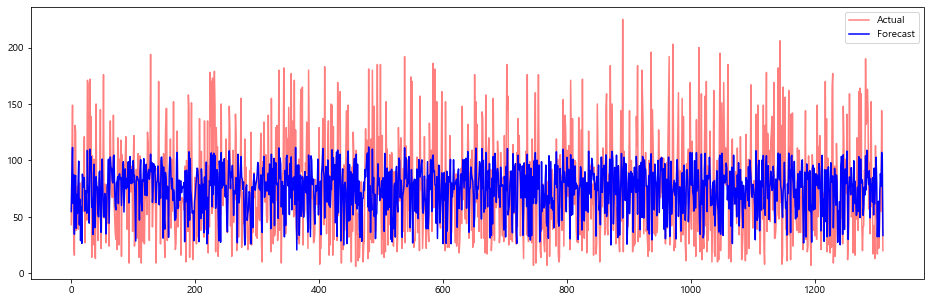

In [193]:
plt.figure(figsize=(16,5))
plt.plot(y_test.values,'-r' ,alpha=0.5)
plt.plot(y_preds,'-b')
plt.legend(['Actual','Forecast'])
plt.show()

In [194]:
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)
print('MSE : {0:.3f}, RMSE : {1:.3F}'.format(mse,rmse))
print('Variance score : {0:3f}'.format(r2_score(y_test,y_preds)))

MSE : 1461.232, RMSE : 38.226
Variance score : 0.224573


### 전체데이터 예측

#### 실제 데이터에 예측값 컬럼 추가

In [195]:
pre = data2.drop('count',axis=1,inplace=False)
pre

,yesterday,today,tomorrow,temp,cloud,precipitation,snowcover,user,hour
0,1,0,0,14.1,0.0,0.0,0.0,1.0,0
1,1,0,0,13.9,2.0,0.0,0.0,1.0,1
2,1,0,0,13.9,4.0,0.0,0.0,1.0,2
3,1,0,0,13.6,8.0,0.0,0.0,1.0,3
4,1,0,0,13.7,10.0,0.0,0.0,1.0,4
5,1,0,0,13.7,8.0,0.0,0.0,1.0,5
6,1,0,0,13.3,7.0,0.0,0.0,1.0,6
7,1,0,0,13.1,3.0,0.0,0.0,1.0,7
8,1,0,0,13.7,7.0,0.0,0.0,1.0,8
9,1,0,0,14.9,1.0,0.0,0.0,1.0,9


In [196]:
taxi['pred'] = model.predict(pre)
taxi.set_index('o_time',inplace=True)

#### 실제값, 예측값 비교

##### 전체

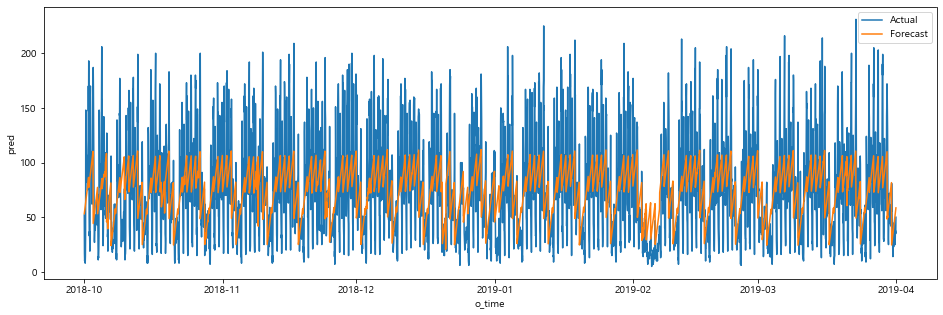

In [198]:
plt.figure(figsize=(16,5))
sns.lineplot(x=taxi.index,y='count',data=taxi)
sns.lineplot(x=taxi.index,y='pred',data=taxi)
plt.legend(['Actual','Forecast'])
plt.show()

##### 한달

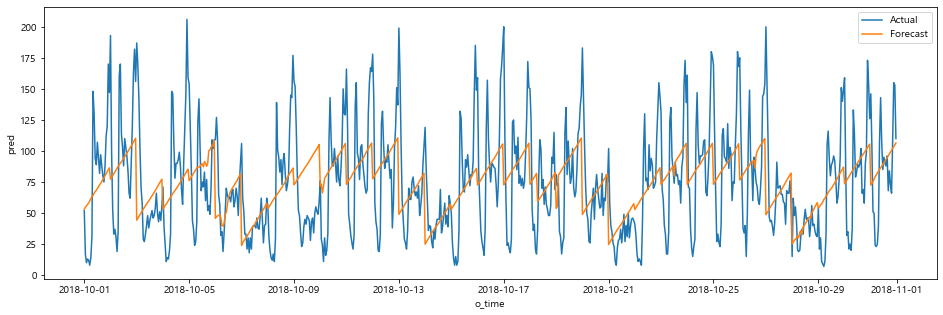

In [199]:
plt.figure(figsize=(16,5))
sns.lineplot(x=taxi['2018-10'].index,y='count',data=taxi['2018-10'])
sns.lineplot(x=taxi['2018-10'].index,y='pred',data=taxi['2018-10'])
plt.legend(['Actual','Forecast'])
plt.show()

##### 일주일

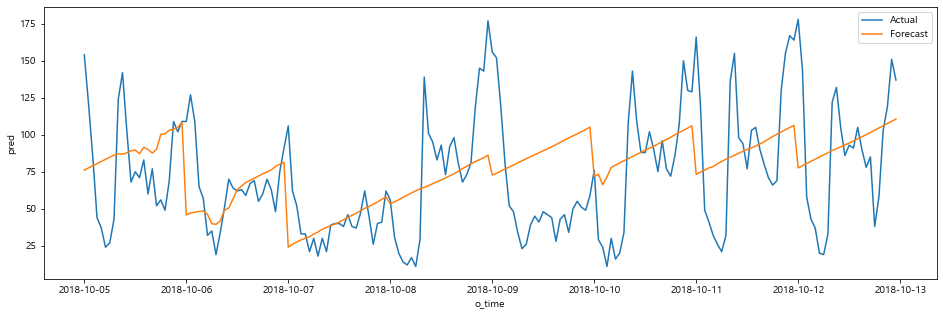

In [200]:
plt.figure(figsize=(16,5))
sns.lineplot(x=taxi['2018-10-05':'2018-10-12'].index,y='count',data=taxi['2018-10-05':'2018-10-12'])
sns.lineplot(x=taxi['2018-10-05':'2018-10-12'].index,y='pred',data=taxi['2018-10-05':'2018-10-12'])
plt.legend(['Actual','Forecast'])
plt.show()

### MinMax + 다항식 특성 사용

In [201]:
X_data2 = MinMaxScaler().fit_transform(X_data)
scaled_data = PolynomialFeatures(degree=2,include_bias=False).fit_transform(X_data2)
scaled_data

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


array([[1.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 1.        , 0.04347826,
        0.00189036],
       [1.        , 0.        , 0.        , ..., 1.        , 0.08695652,
        0.00756144],
       ...,
       [1.        , 1.        , 0.        , ..., 1.        , 0.91304348,
        0.83364839],
       [1.        , 1.        , 0.        , ..., 1.        , 0.95652174,
        0.91493384],
       [1.        , 1.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

#### 최적의 alpha값 찾기

In [202]:
ridge_alphas = [0.1,0.01,0.015,0.02,0.5,1,10,20,50,100]
coeff_ridge_df = get_linear_reg_eval('Ridge',params=ridge_alphas,X_data_n=scaled_data,y_target_n=y_target)

#######  Ridge  #######
alpha 0.1일 때 4폴드 세트의 평균 RMSE : 33.466
alpha 0.01일 때 4폴드 세트의 평균 RMSE : 34.600
alpha 0.015일 때 4폴드 세트의 평균 RMSE : 34.319
alpha 0.02일 때 4폴드 세트의 평균 RMSE : 34.127
alpha 0.5일 때 4폴드 세트의 평균 RMSE : 33.411
alpha 1일 때 4폴드 세트의 평균 RMSE : 33.405
alpha 10일 때 4폴드 세트의 평균 RMSE : 33.886
alpha 20일 때 4폴드 세트의 평균 RMSE : 34.483
alpha 50일 때 4폴드 세트의 평균 RMSE : 35.642
alpha 100일 때 4폴드 세트의 평균 RMSE : 36.649


#### 데이터셋 분할

In [203]:
y_target = data2['count']
X_data = data2.drop(['count'], axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(scaled_data, y_target, test_size=0.3, random_state=156)

#### 모델생성

In [204]:
model = Ridge(alpha=1)
model.fit(X_train,y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

#### 검증

In [205]:
y_preds = model.predict(X_test)
y_preds

array([103.48272613,  72.43770952, 148.77658094, ..., 121.40475839,
       108.17604691,  26.27709786])

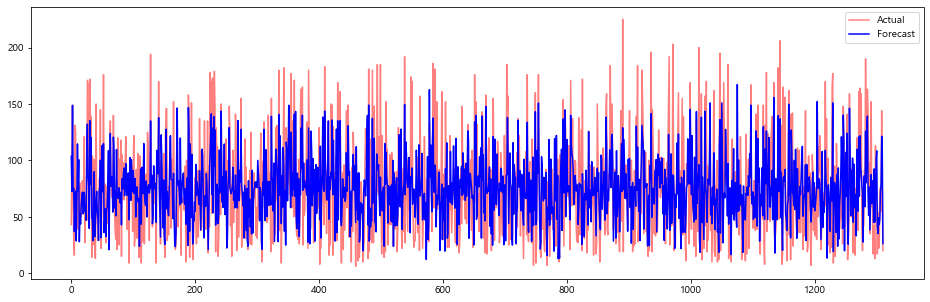

In [208]:
plt.figure(figsize=(16,5))\
plt.plot(y_test.values,'-r' ,alpha=0.5)
plt.plot(y_preds,'-b')
plt.legend(['Actual','Forecast'])
plt.show()

In [209]:
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)
print('MSE : {0:.3f}, RMSE : {1:.3F}'.format(mse,rmse))
print('Variance score : {0:3f}'.format(r2_score(y_test,y_preds)))

MSE : 1043.859, RMSE : 32.309
Variance score : 0.446059


## Lasso

### 라쏘회귀 모델 생성 전 최적 alpha 파라미터 확인

#### alpha 파라미터 세트 이용 자동화함수를 사용하여 각 RMSE 확인

In [282]:
lasso_alphas = [0.0001,0.001,0.01,0.05,0.1,0.5,1,3,5]
coeff_lasso_df = get_linear_reg_eval('Lasso',params=lasso_alphas,X_data_n=X_data,y_target_n=y_target)

#######  Lasso  #######
alpha 0.0001일 때 4폴드 세트의 평균 RMSE : 39.386
alpha 0.001일 때 4폴드 세트의 평균 RMSE : 39.389
alpha 0.01일 때 4폴드 세트의 평균 RMSE : 39.438
alpha 0.05일 때 4폴드 세트의 평균 RMSE : 39.575
alpha 0.1일 때 4폴드 세트의 평균 RMSE : 39.579
alpha 0.5일 때 4폴드 세트의 평균 RMSE : 39.649
alpha 1일 때 4폴드 세트의 평균 RMSE : 39.732
alpha 3일 때 4폴드 세트의 평균 RMSE : 40.440
alpha 5일 때 4폴드 세트의 평균 RMSE : 41.840


#### 파라미터 값에 따른 회귀계수 확인

In [283]:
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.0001,alpha:0.001,alpha:0.01,alpha:0.05,alpha:0.1,alpha:0.5,alpha:1,alpha:3,alpha:5
user,119.865028,119.172659,112.248773,81.474226,43.002279,0.000000,0.000000,0.000000,0.000000
tomorrow,4.406838,4.404560,4.381956,4.283098,4.162044,1.950248,0.000000,0.000000,0.000000
hour,1.415042,1.414959,1.414128,1.410435,1.405777,1.395181,1.384920,1.328785,1.279864
snowcover,0.739929,0.732661,0.660008,0.337308,0.000000,0.000000,0.000000,-0.000000,-0.000000
temp,-0.074651,-0.074787,-0.076144,-0.082178,-0.089489,-0.101557,-0.099760,-0.033389,-0.000000
cloud,-0.086668,-0.086395,-0.083664,-0.071527,-0.056940,-0.046910,-0.033241,-0.000000,-0.000000
precipitation,-2.126696,-2.123641,-2.093096,-1.957326,-1.790324,-0.658745,-0.000000,-0.000000,-0.000000
yesterday,-20.345326,-20.340619,-20.293195,-20.079209,-19.803599,-19.089407,-18.098635,-10.926606,-3.742368
today,-27.731203,-27.723892,-27.651021,-27.329304,-26.936519,-24.512325,-21.977220,-14.808642,-7.673501


### Lasso 의 alpha 값을 다르게 적용하고 다양한 데이터 변환방법에 따른 RMSE 확인

In [224]:
# Lasso 의 alpha 값을 다르게 적용하고 다양한 데이터 변환방법에 따른 RMSE 확인
lasso_alphas = [0.0001,0.001,0.01,0.05,0.1,0.5,1,3,5]

# 5개 방식 변환 확인
# 원본그대로, 표준정규분포, 표준정규분포 + 다항식특성, 최대/최소 정규화, 최대/최소 정규화 + 다항식 특성, 로그변환
scale_methods=[(None,None),('Standard',None),('Standard',2),('MinMax',None),('MinMax',2),('Log',None)]

for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1], input_data=X_data)
    print('\n## 변환유형 : {0}, Polynomial Degree:{1}'.format(scale_method[0],scale_method[1]))
    get_linear_reg_eval('Lasso',params=lasso_alphas, X_data_n=X_data_scaled, y_target_n=y_target, verbose=False)


## 변환유형 : None, Polynomial Degree:None
alpha 0.0001일 때 4폴드 세트의 평균 RMSE : 39.386
alpha 0.001일 때 4폴드 세트의 평균 RMSE : 39.389
alpha 0.01일 때 4폴드 세트의 평균 RMSE : 39.438
alpha 0.05일 때 4폴드 세트의 평균 RMSE : 39.575
alpha 0.1일 때 4폴드 세트의 평균 RMSE : 39.579
alpha 0.5일 때 4폴드 세트의 평균 RMSE : 39.649
alpha 1일 때 4폴드 세트의 평균 RMSE : 39.732
alpha 3일 때 4폴드 세트의 평균 RMSE : 40.440
alpha 5일 때 4폴드 세트의 평균 RMSE : 41.840

## 변환유형 : Standard, Polynomial Degree:None
alpha 0.0001일 때 4폴드 세트의 평균 RMSE : 39.386
alpha 0.001일 때 4폴드 세트의 평균 RMSE : 39.386
alpha 0.01일 때 4폴드 세트의 평균 RMSE : 39.384
alpha 0.05일 때 4폴드 세트의 평균 RMSE : 39.378
alpha 0.1일 때 4폴드 세트의 평균 RMSE : 39.377
alpha 0.5일 때 4폴드 세트의 평균 RMSE : 39.499
alpha 1일 때 4폴드 세트의 평균 RMSE : 39.579
alpha 3일 때 4폴드 세트의 평균 RMSE : 39.861
alpha 5일 때 4폴드 세트의 평균 RMSE : 40.409

## 변환유형 : Standard, Polynomial Degree:2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective

alpha 0.0001일 때 4폴드 세트의 평균 RMSE : 43.064


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha 0.001일 때 4폴드 세트의 평균 RMSE : 40.902


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha 0.01일 때 4폴드 세트의 평균 RMSE : 36.658
alpha 0.05일 때 4폴드 세트의 평균 RMSE : 34.387
alpha 0.1일 때 4폴드 세트의 평균 RMSE : 33.646
alpha 0.5일 때 4폴드 세트의 평균 RMSE : 33.547
alpha 1일 때 4폴드 세트의 평균 RMSE : 33.483
alpha 3일 때 4폴드 세트의 평균 RMSE : 34.549
alpha 5일 때 4폴드 세트의 평균 RMSE : 36.160

## 변환유형 : MinMax, Polynomial Degree:None
alpha 0.0001일 때 4폴드 세트의 평균 RMSE : 39.386
alpha 0.001일 때 4폴드 세트의 평균 RMSE : 39.383
alpha 0.01일 때 4폴드 세트의 평균 RMSE : 39.395
alpha 0.05일 때 4폴드 세트의 평균 RMSE : 39.575
alpha 0.1일 때 4폴드 세트의 평균 RMSE : 39.560
alpha 0.5일 때 4폴드 세트의 평균 RMSE : 39.636

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



alpha 1일 때 4폴드 세트의 평균 RMSE : 39.826
alpha 3일 때 4폴드 세트의 평균 RMSE : 41.518
alpha 5일 때 4폴드 세트의 평균 RMSE : 42.903

## 변환유형 : MinMax, Polynomial Degree:2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

alpha 0.0001일 때 4폴드 세트의 평균 RMSE : 36.845


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

alpha 0.001일 때 4폴드 세트의 평균 RMSE : 34.280


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha 0.01일 때 4폴드 세트의 평균 RMSE : 33.444
alpha 0.05일 때 4폴드 세트의 평균 RMSE : 33.461
alpha 0.1일 때 4폴드 세트의 평균 RMSE : 33.640
alpha 0.5일 때 4폴드 세트의 평균 RMSE : 36.023
alpha 1일 때 4폴드 세트의 평균 RMSE : 36.682
alpha 3일 때 4폴드 세트의 평균 RMSE : 40.570
alpha 5일 때 4폴드 세트의 평균 RMSE : 42.903

## 변환유형 : Log, Polynomial Degree:None


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log1p
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log1p
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### 모델 생성

In [259]:
model = Lasso(alpha=0.001)
model.fit(X_train,y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

#### 검증

In [260]:
y_preds = model.predict(X_test)
y_preds

array([ 54.68732203,  89.61284141, 111.44111311, ..., 107.09151983,
       100.93719152,  33.41245597])

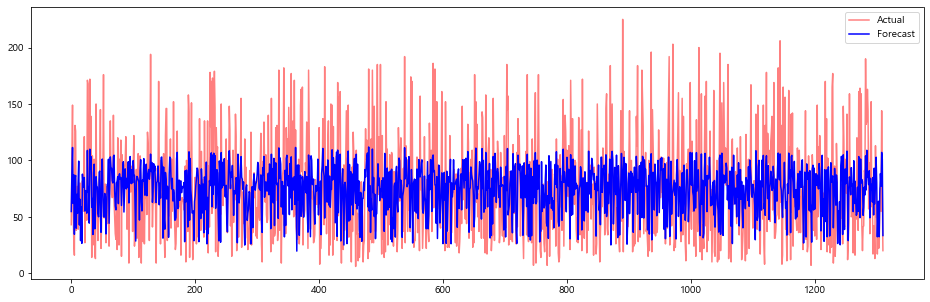

In [269]:
plt.figure(figsize=(16,5))
plt.plot(y_test.values,'-r' ,alpha=0.5)
plt.plot(y_preds,'-b')
plt.legend(['Actual','Forecast'])
plt.show()

In [268]:
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)
print('MSE : {0:.3f}, RMSE : {1:.3F}'.format(mse,rmse))
print('Variance score : {0:3f}'.format(r2_score(y_test,y_preds)))

MSE : 1461.147, RMSE : 38.225
Variance score : 0.224618


### 전체데이터 예측

#### 전체데이터에 예측값 컬럼 추가

In [262]:
pre = data2.drop('count',axis=1,inplace=False)
pre

,yesterday,today,tomorrow,temp,cloud,precipitation,snowcover,user,hour
0,1,0,0,14.1,0.0,0.0,0.0,1.0,0
1,1,0,0,13.9,2.0,0.0,0.0,1.0,1
2,1,0,0,13.9,4.0,0.0,0.0,1.0,2
3,1,0,0,13.6,8.0,0.0,0.0,1.0,3
4,1,0,0,13.7,10.0,0.0,0.0,1.0,4
5,1,0,0,13.7,8.0,0.0,0.0,1.0,5
6,1,0,0,13.3,7.0,0.0,0.0,1.0,6
7,1,0,0,13.1,3.0,0.0,0.0,1.0,7
8,1,0,0,13.7,7.0,0.0,0.0,1.0,8
9,1,0,0,14.9,1.0,0.0,0.0,1.0,9


In [263]:
taxi['pred'] = model.predict(pre)
taxi.set_index('o_time',inplace=True)

#### 실제값, 예측값 비교

##### 전체기간

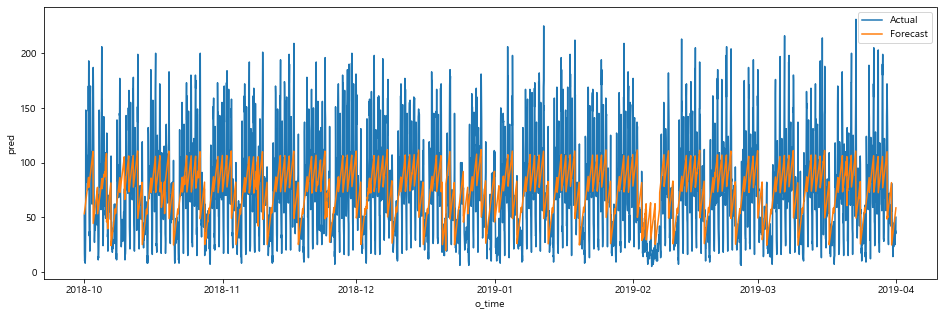

In [265]:
plt.figure(figsize=(16,5))
sns.lineplot(x=taxi.index,y='count',data=taxi)
sns.lineplot(x=taxi.index,y='pred',data=taxi)
plt.legend(['Actual','Forecast'])
plt.show()

##### 2018-10 한달

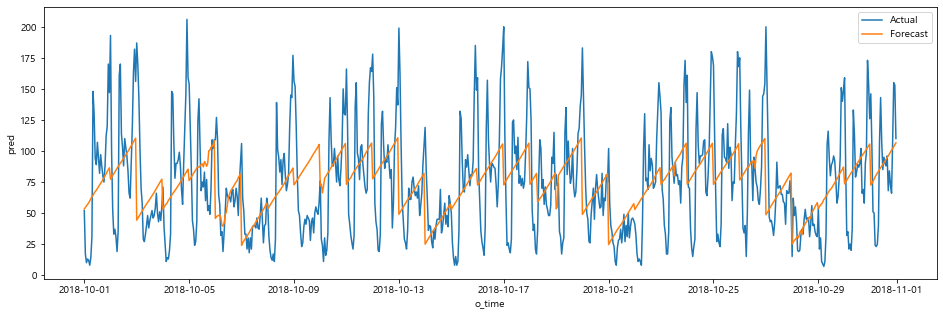

In [266]:
plt.figure(figsize=(16,5))
sns.lineplot(x=taxi['2018-10'].index,y='count',data=taxi['2018-10'])
sns.lineplot(x=taxi['2018-10'].index,y='pred',data=taxi['2018-10'])
plt.legend(['Actual','Forecast'])
plt.show()

##### 2018-10-05 ~ 2018-10-12 일주일

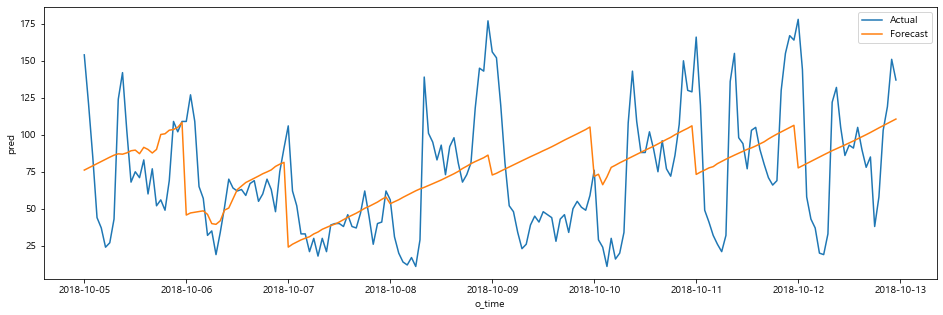

In [267]:
plt.figure(figsize=(16,5))
sns.lineplot(x=taxi['2018-10-05':'2018-10-12'].index,y='count',data=taxi['2018-10-05':'2018-10-12'])
sns.lineplot(x=taxi['2018-10-05':'2018-10-12'].index,y='pred',data=taxi['2018-10-05':'2018-10-12'])
plt.legend(['Actual','Forecast'])
plt.show()

## ElasticNet

### 엘라스틱넷회귀 모델 생성 전 최적 alpha 파라미터 확인

#### alpha 파라미터 세트 이용 자동화함수를 사용하여 각 RMSE 확인

In [301]:
# l1_ratio = 0.7 고정
elastic_alphas = [0.0001,0.001,0.01,0.05,0.1,0.5,1,3,5]
coeff_elastic_df = get_linear_reg_eval('ElasticNet',params=elastic_alphas,X_data_n=X_data,y_target_n=y_target)

#######  ElasticNet  #######
alpha 0.0001일 때 4폴드 세트의 평균 RMSE : 39.396
alpha 0.001일 때 4폴드 세트의 평균 RMSE : 39.467
alpha 0.01일 때 4폴드 세트의 평균 RMSE : 39.574
alpha 0.05일 때 4폴드 세트의 평균 RMSE : 39.606
alpha 0.1일 때 4폴드 세트의 평균 RMSE : 39.642
alpha 0.5일 때 4폴드 세트의 평균 RMSE : 40.199
alpha 1일 때 4폴드 세트의 평균 RMSE : 40.879
alpha 3일 때 4폴드 세트의 평균 RMSE : 42.252
alpha 5일 때 4폴드 세트의 평균 RMSE : 42.798


#### 파라미터 값에 따른 회귀계수 확인

In [285]:
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.0001,alpha:0.001,alpha:0.01,alpha:0.05,alpha:0.1,alpha:0.5,alpha:1,alpha:3,alpha:5
user,117.189845,97.051836,34.616785,7.311221,2.622018,0.000000,0.000000,0.000000,0.000000
tomorrow,4.418025,4.495057,4.629933,4.164780,3.594942,1.274467,0.168676,0.000000,0.000000
hour,1.414756,1.412587,1.405763,1.402155,1.400630,1.390281,1.377181,1.320024,1.271369
snowcover,0.739800,0.731108,0.638613,0.265523,0.000000,-0.000000,-0.000000,-0.000000,-0.000000
temp,-0.075022,-0.077849,-0.086759,-0.091268,-0.091983,-0.084580,-0.074961,-0.020604,-0.000000
cloud,-0.085832,-0.079485,-0.059326,-0.047905,-0.044147,-0.036534,-0.021218,-0.000000,-0.000000
precipitation,-2.125609,-2.114377,-2.050650,-1.865106,-1.669658,-0.646902,-0.000000,-0.000000,-0.000000
yesterday,-20.328362,-20.198415,-19.715292,-19.007299,-18.262582,-13.287278,-9.476967,-3.519014,-1.552596
today,-27.722377,-27.644614,-27.144826,-25.552446,-23.883894,-15.806313,-10.886538,-4.108820,-1.928865


### ElasticNet 의 alpha 값을 다르게 적용하고 다양한 데이터 변환방법에 따른 RMSE 확인

In [303]:
# ElasticNet 의 alpha 값을 다르게 적용하고 다양한 데이터 변환방법에 따른 RMSE 확인
elastic_alphas = [0.0001,0.001,0.01,0.05,0.1,0.5,1,3,5]

# 5개 방식 변환 확인
# 원본그대로, 표준정규분포, 표준정규분포 + 다항식특성, 최대/최소 정규화, 최대/최소 정규화 + 다항식 특성, 로그변환
scale_methods=[(None,None),('Standard',None),('Standard',2),('MinMax',None),('MinMax',2),('Log',None)]

for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1], input_data=X_data)
    print('\n## 변환유형 : {0}, Polynomial Degree:{1}'.format(scale_method[0],scale_method[1]))
    get_linear_reg_eval('ElasticNet',params=lasso_alphas, X_data_n=X_data_scaled, y_target_n=y_target, verbose=False)


## 변환유형 : None, Polynomial Degree:None
alpha 0.0001일 때 4폴드 세트의 평균 RMSE : 39.396
alpha 0.001일 때 4폴드 세트의 평균 RMSE : 39.467
alpha 0.01일 때 4폴드 세트의 평균 RMSE : 39.574
alpha 0.05일 때 4폴드 세트의 평균 RMSE : 39.606
alpha 0.1일 때 4폴드 세트의 평균 RMSE : 39.642
alpha 0.5일 때 4폴드 세트의 평균 RMSE : 40.199
alpha 1일 때 4폴드 세트의 평균 RMSE : 40.879
alpha 3일 때 4폴드 세트의 평균 RMSE : 42.252
alpha 5일 때 4폴드 세트의 평균 RMSE : 42.798

## 변환유형 : Standard, Polynomial Degree:None
alpha 0.0001일 때 4폴드 세트의 평균 RMSE : 39.386
alpha 0.001일 때 4폴드 세트의 평균 RMSE : 39.386
alpha 0.01일 때 4폴드 세트의 평균 RMSE : 39.384
alpha 0.05일 때 4폴드 세트의 평균 RMSE : 39.383
alpha 0.1일 때 4폴드 세트의 평균 RMSE : 39.389
alpha 0.5일 때 4폴드 세트의 평균 RMSE : 39.566
alpha 1일 때 4폴드 세트의 평균 RMSE : 39.832
alpha 3일 때 4폴드 세트의 평균 RMSE : 40.914
alpha 5일 때 4폴드 세트의 평균 RMSE : 41.814

## 변환유형 : Standard, Polynomial Degree:2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective

alpha 0.0001일 때 4폴드 세트의 평균 RMSE : 40.401


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

alpha 0.001일 때 4폴드 세트의 평균 RMSE : 37.821
alpha 0.01일 때 4폴드 세트의 평균 RMSE : 34.836
alpha 0.05일 때 4폴드 세트의 평균 RMSE : 33.752
alpha 0.1일 때 4폴드 세트의 평균 RMSE : 33.692
alpha 0.5일 때 4폴드 세트의 평균 RMSE : 33.861
alpha 1일 때 4폴드 세트의 평균 RMSE : 34.344
alpha 3일 때 4폴드 세트의 평균 RMSE : 37.072
alpha 5일 때 4폴드 세트의 평균 RMSE : 39.115

## 변환유형 : MinMax, Polynomial Degree:None
alpha 0.0001일 때 4폴드 세트의 평균 RMSE : 39.383
alpha 0.001일 때 4폴드 세트의 평균 RMSE : 39.400
alpha 0.01일 때 4폴드 세트의 평균 RMSE : 39.519
alpha 0.05일 때 4폴드 세트의 평균 RMSE : 39.600
alpha 0.1일 때 4폴드 세트의 평균 RMSE : 39.685
alpha 0.5일 때 4폴드 세트의 평균 RMSE : 40.644
alpha 1일 때 4폴드 세트의 평균 RMSE : 41.570
alpha 3일 때 4폴드 세트의 평균 RMSE : 43.232

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



alpha 5일 때 4폴드 세트의 평균 RMSE : 43.830

## 변환유형 : MinMax, Polynomial Degree:2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

alpha 0.0001일 때 4폴드 세트의 평균 RMSE : 33.473


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

alpha 0.001일 때 4폴드 세트의 평균 RMSE : 33.405
alpha 0.01일 때 4폴드 세트의 평균 RMSE : 33.932
alpha 0.05일 때 4폴드 세트의 평균 RMSE : 35.755
alpha 0.1일 때 4폴드 세트의 평균 RMSE : 36.768
alpha 0.5일 때 4폴드 세트의 평균 RMSE : 38.933
alpha 1일 때 4폴드 세트의 평균 RMSE : 39.826
alpha 3일 때 4폴드 세트의 평균 RMSE : 41.938
alpha 5일 때 4폴드 세트의 평균 RMSE : 43.133

## 변환유형 : Log, Polynomial Degree:None


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log1p
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log1p
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### 모델 생성

In [306]:
model = ElasticNet(alpha=0.0001,l1_ratio=0.7)
model.fit(X_train,y_train)

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.7,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

#### 검증

In [307]:
y_preds = model.predict(X_test)
y_preds

array([ 54.68606077,  89.59659368, 111.43794844, ..., 107.08737014,
       100.91799696,  33.41394829])

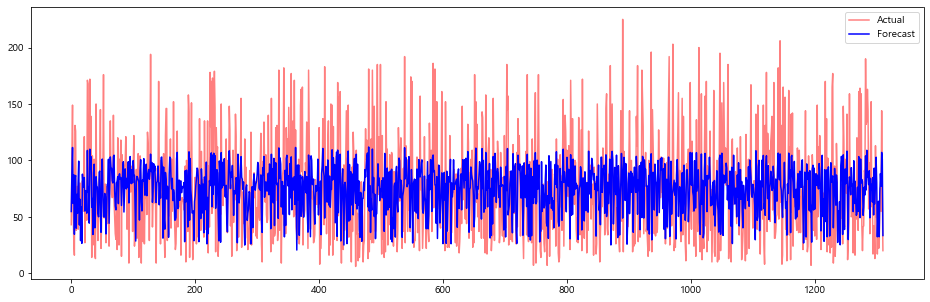

In [308]:
plt.figure(figsize=(16,5))
plt.plot(y_test.values,'-r' ,alpha=0.5)
plt.plot(y_preds,'-b')
plt.legend(['Actual','Forecast'])
plt.show()

In [309]:
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)
print('MSE : {0:.3f}, RMSE : {1:.3F}'.format(mse,rmse))
print('Variance score : {0:3f}'.format(r2_score(y_test,y_preds)))

MSE : 1461.224, RMSE : 38.226
Variance score : 0.224577
